In [1]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

----
## Step 1. Download data
----

### 1a. Defining your area of interest

The `g` geometry parameter is used to download data for a point, line or polygon. Geometry can be written in various formats including WKT, GeoJSON, KML. The examples below use WKT (Well Known Text) format.

#### To get data for a grid cell ...

In [2]:
point = 'POINT(-121.4944 38.5816)' #Sacramento
#point = 'POINT(-121.6219 39.7596)' # paradise
location = 'Sacramento'

In [3]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Name of boundary layer in API (Locagrid)
resource = 'locagrid'

#Get ID
url = api + '/' + resource + '/?intersects=' +  point

response = requests.get(url)
data = response.json()
data = data['features'][0]
id = data['id']
print(id)

37907


In [4]:
response = requests.get('http://api.cal-adapt.org/api/series/pr_day_CNRM-CM5_rcp85/rasters/')
data = response.json()

In [5]:
x = data['results'][0]

In [6]:
x['units']

'kg/m2/s'

### 1b. Download observed daily precp

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. 
The code in the next cell contains a bunch of functions to:
    - fetch daily data given an ID and params
    - return a new Pandas dataframe that contains all the data

#### Imperail = True, gives precip in inches/day


In [7]:
# Testing beofre setting for loop

slug = 'pr_day_CanESM2_rcp85'
url = api + '/series/' + slug + '/events/?ref=/api/locagrid/%s/&imperial=True&stat=mean' % id
response = requests.get(url)
# Get data
if response.ok:
    data = response.json()
    df = pd.DataFrame(data)
    df.set_index('index', inplace = True)
    df.index = pd.to_datetime(df.index)

In [8]:
df.head()

,name,data
index,,
2006-01-01 00:00:00+00:00,pr_day_CanESM2_rcp85,0.008847
2006-01-02 00:00:00+00:00,pr_day_CanESM2_rcp85,0.000000
2006-01-03 00:00:00+00:00,pr_day_CanESM2_rcp85,0.000000
2006-01-04 00:00:00+00:00,pr_day_CanESM2_rcp85,0.019911
2006-01-05 00:00:00+00:00,pr_day_CanESM2_rcp85,0.001672


In [9]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'
# Request header
headers = {'ContentType': 'json'}

def process_daily_data(slug):
    # Make request
    url = api + '/series/' + slug + '/events/?ref=/api/locagrid/%s/&imperial=True&stat=mean' % id
    response = requests.get(url)
    #print(response)
    # Get data
    if response.ok:
        data = response.json()
        df = pd.DataFrame(data)
        df.set_index('index', inplace = True)
        df.index = pd.to_datetime(df.index)
    
    else:
        print('Failed to download:')
    return df

### 1c. Download projected daily precp

The projected daily timeseries are form 2006 - 2099/2100. You can easily modify the code to add/subtract models, scenarios, climate variables

In [10]:
def get_projections():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['pr']
    period = ['day']
    models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5', 'ACCESS1-0', 'CCSM4', 'CESM1-BGC', 'CMCC-CMS', 'GFDL-CM3', 'HadGEM2-CC']
    # Cal Adapt support only ten priority models
    #models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5']
    scenarios = ['historical', 'rcp85']
    zipped = itertools.product(climvar, period, models, scenarios)

    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [11]:
projectedDF = get_projections()
#units: inches/day
projectedDF

,name,data
index,,
1950-01-01 00:00:00+00:00,pr_day_CanESM2_historical,1.006578
1950-01-02 00:00:00+00:00,pr_day_CanESM2_historical,0.438872
1950-01-03 00:00:00+00:00,pr_day_CanESM2_historical,0.010421
1950-01-04 00:00:00+00:00,pr_day_CanESM2_historical,0.206090
1950-01-05 00:00:00+00:00,pr_day_CanESM2_historical,0.002075
1950-01-06 00:00:00+00:00,pr_day_CanESM2_historical,0.000000
1950-01-07 00:00:00+00:00,pr_day_CanESM2_historical,0.000000
1950-01-08 00:00:00+00:00,pr_day_CanESM2_historical,0.005568
1950-01-09 00:00:00+00:00,pr_day_CanESM2_historical,0.008045


In [12]:
# Keep only required parameters in slug
projectedDF['Climate Data'] = projectedDF['name'].str.split('_', expand=True)[2] 
projectedDF.index.name = 'Date'
projectedDF.drop(columns= 'name', inplace = True)
projectedDF.head()

,data,Climate Data
Date,,
1950-01-01 00:00:00+00:00,1.006578,CanESM2
1950-01-02 00:00:00+00:00,0.438872,CanESM2
1950-01-03 00:00:00+00:00,0.010421,CanESM2
1950-01-04 00:00:00+00:00,0.206090,CanESM2
1950-01-05 00:00:00+00:00,0.002075,CanESM2


In [13]:
projectedDF = projectedDF.pivot_table( values = 'data', index = 'Date', columns = 'Climate Data')

In [14]:
projectedDF.head()

Climate Data,ACCESS1-0,CCSM4,CESM1-BGC,CMCC-CMS,CNRM-CM5,CanESM2,GFDL-CM3,HadGEM2-CC,HadGEM2-ES,MIROC5
Date,,,,,,,,,,
1950-01-01 00:00:00+00:00,0.022689,0.000414,0.012912,0.577939,0.000636,1.006578,0.000000,0.000000,0.000020,0.000000
1950-01-02 00:00:00+00:00,0.267866,0.001206,0.019540,0.154440,0.000000,0.438872,0.000494,0.000000,0.002479,0.000000
1950-01-03 00:00:00+00:00,0.495777,0.105037,0.006282,0.004055,0.000000,0.010421,0.000000,0.271619,0.001107,0.000000
1950-01-04 00:00:00+00:00,0.540521,0.033622,0.000000,0.000000,0.000000,0.206090,0.003665,0.482091,0.335518,0.004642
1950-01-05 00:00:00+00:00,0.078564,0.022436,0.000000,0.000000,0.000000,0.002075,0.000000,0.531948,0.003630,0.000000


In [15]:
# Visulazing first few rows 
# Units = inches/day
#change it to mm/day
projectedDF = projectedDF.apply(lambda x: x*25.4) #change units to precp mm/day
projectedDF.head()

Climate Data,ACCESS1-0,CCSM4,CESM1-BGC,CMCC-CMS,CNRM-CM5,CanESM2,GFDL-CM3,HadGEM2-CC,HadGEM2-ES,MIROC5
Date,,,,,,,,,,
1950-01-01 00:00:00+00:00,0.576303,0.010514,0.327971,14.679662,0.016156,25.567080,0.000000,0.000000,0.000506,0.000000
1950-01-02 00:00:00+00:00,6.803789,0.030645,0.496309,3.922776,0.000000,11.147354,0.012547,0.000000,0.062977,0.000000
1950-01-03 00:00:00+00:00,12.592727,2.667930,0.159558,0.102994,0.000000,0.264701,0.000000,6.899122,0.028116,0.000000
1950-01-04 00:00:00+00:00,13.729244,0.854006,0.000000,0.000000,0.000000,5.234695,0.093096,12.245118,8.522160,0.117907
1950-01-05 00:00:00+00:00,1.995517,0.569869,0.000000,0.000000,0.000000,0.052697,0.000000,13.511478,0.092205,0.000000


In [16]:
projectedDF['avg'] = projectedDF.mean(axis = 1)

In [17]:
wind = projectedDF[['avg']]
wind.head()

Climate Data,avg
Date,
1950-01-01 00:00:00+00:00,4.117819
1950-01-02 00:00:00+00:00,2.247640
1950-01-03 00:00:00+00:00,2.271515
1950-01-04 00:00:00+00:00,4.079623
1950-01-05 00:00:00+00:00,1.622177


In [18]:
wind.dtypes

Climate Data
avg    float64
dtype: object

In [19]:
wind.index = wind.index.date

In [20]:
wind.index = pd.to_datetime(wind.index)

In [21]:
wind.index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', length=55152)

In [22]:
type(wind.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [23]:
wind['year'] = wind.index.year
wind['month'] =wind.index.month
wind['day'] = wind.index.day
wind['period'] = wind.index.strftime('%m-%d')
#wind.index = wind.index.dt.strftime('%H:%M:%S')
#wind['period']=wind.apply(lambda x:'%d/%d' % (x.month,x.day),axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [24]:
wind.head()

Climate Data,avg,year,month,day,period
1950-01-01,4.117819,1950,1,1,01-01
1950-01-02,2.247640,1950,1,2,01-02
1950-01-03,2.271515,1950,1,3,01-03
1950-01-04,4.079623,1950,1,4,01-04
1950-01-05,1.622177,1950,1,5,01-05


In [25]:
pr_year = wind[(wind.month == 10) | (wind.month == 11) | (wind.month == 12)]

In [26]:
pr_year.head()

Climate Data,avg,year,month,day,period
1950-10-01,1.351838,1950,10,1,10-01
1950-10-02,0.266429,1950,10,2,10-02
1950-10-03,0.470444,1950,10,3,10-03
1950-10-04,1.267103,1950,10,4,10-04
1950-10-05,0.388588,1950,10,5,10-05


In [27]:
# Summ data by year
ten_percent_of_historical_avg = pr_year.loc['1961-10-01':'1990-12-31'].groupby(['year']).sum()

In [28]:
ten_percent_of_historical_avg.head()

Climate Data,avg,month,day
year,,,
1961,204.543833,1012,1457
1962,178.716244,1012,1457
1963,117.798929,1012,1457
1964,235.976341,1012,1457
1965,196.937005,1012,1457


In [29]:
# Find mean of summed data and take 10% of that
ten_percent_of_historical_avg = ten_percent_of_historical_avg['avg'].mean()*0.1

In [30]:
ten_percent_of_historical_avg

16.879573733231883

In [31]:
#projected = pr_year.loc['1991-01-01' : '2100-12-31']
projected = pr_year

In [32]:
proj_by_years_in_cols = projected.pivot_table( values = 'avg', index = 'period', columns = 'year')

In [33]:
proj_by_years_in_cols.tail()

year,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
period,,,,,,,,,,,,,,,,,,,,,
12-27,4.598372,6.863042,1.939154,5.620863,4.034788,4.700023,2.103524,3.721452,3.157139,6.531841,...,1.166599,3.983093,2.051791,3.853201,2.001106,6.583017,8.975573,1.027585,1.021052,0.867195
12-28,4.937475,3.367942,2.187887,6.251772,4.825073,3.545572,2.679725,2.878656,2.579778,4.942714,...,2.546885,0.851674,1.278139,9.673763,0.739897,5.699200,9.787364,1.608777,4.627593,1.720435
12-29,5.635726,3.014418,8.476345,4.223564,7.023786,0.499011,1.733333,6.087507,2.216535,5.397315,...,2.549425,0.373398,0.337829,8.000799,1.758600,1.534207,10.324493,2.686591,7.321340,5.264103
12-30,3.803859,5.334012,2.063532,1.985353,4.848098,2.108496,2.708450,3.697958,2.100200,3.234640,...,6.842288,2.364050,3.275631,2.106692,8.157411,3.380015,12.731197,2.451118,5.502981,4.807841
12-31,3.091398,10.155314,3.587530,0.636247,7.755706,1.559886,1.009064,2.126932,7.904489,5.127765,...,4.551004,3.746541,3.167718,1.179667,5.493492,2.419658,9.508834,4.191331,2.359469,4.115626


In [34]:
proj_cumsum = proj_by_years_in_cols.cumsum()

In [35]:
proj_cumsum.tail()

year,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
period,,,,,,,,,,,,,,,,,,,,,
12-27,135.642682,161.589461,176.228321,161.105681,132.186181,157.753352,118.246195,140.240997,137.553336,203.731412,...,155.554489,129.888707,96.764181,185.790166,110.093484,126.207335,116.934569,135.935191,141.401226,181.955030
12-28,140.580156,164.957404,178.416208,167.357453,137.011254,161.298924,120.925920,143.119652,140.133114,208.674126,...,158.101374,130.740381,98.042320,195.463929,110.833382,131.906534,126.721933,137.543968,146.028819,183.675465
12-29,146.215882,167.971822,186.892553,171.581016,144.035039,161.797935,122.659253,149.207159,142.349650,214.071442,...,160.650800,131.113780,98.380148,203.464728,112.591982,133.440741,137.046426,140.230559,153.350159,188.939568
12-30,150.019741,173.305834,188.956086,173.566369,148.883137,163.906431,125.367703,152.905116,144.449849,217.306081,...,167.493088,133.477830,101.655779,205.571421,120.749392,136.820756,149.777623,142.681677,158.853140,193.747409
12-31,153.111140,183.461148,192.543616,174.202616,156.638843,165.466317,126.376767,155.032049,152.354338,222.433846,...,172.044092,137.224371,104.823497,206.751088,126.242884,139.240414,159.286457,146.873009,161.212609,197.863035


In [36]:
directory = r'C:\Users\lkaur\Work summer 2019\cumsum_precip.csv'
excel_file = proj_cumsum.to_csv(directory, header=True) 

In [37]:
# Finding the row where threshold reaches 
# proj_by_years_in_cols[1992].cumsum().values.searchsorted(ten_percent_of_historical_avg)

In [38]:
# Finding the row where threshold reaches 
ten_percent = []
def find_threshold(x):
    ten_percent.append(x.cumsum().values.searchsorted(ten_percent_of_historical_avg))

In [39]:
for x in range(1950, 2101):
    find_threshold(proj_by_years_in_cols[x])

In [40]:
x = proj_by_years_in_cols.iloc[1, ten_percent[2]]

In [41]:
proj_by_years_in_cols.shape

(92, 151)

In [42]:
ten_percent

[24,
 22,
 21,
 29,
 28,
 24,
 20,
 21,
 18,
 21,
 29,
 23,
 25,
 32,
 25,
 26,
 36,
 2,
 20,
 14,
 11,
 1,
 20,
 17,
 23,
 22,
 33,
 21,
 32,
 19,
 31,
 26,
 25,
 19,
 26,
 26,
 26,
 35,
 37,
 18,
 29,
 18,
 36,
 25,
 35,
 26,
 21,
 17,
 34,
 40,
 31,
 40,
 25,
 39,
 30,
 35,
 38,
 23,
 10,
 26,
 24,
 25,
 20,
 19,
 23,
 44,
 12,
 26,
 19,
 26,
 31,
 27,
 27,
 5,
 34,
 26,
 35,
 43,
 9,
 33,
 24,
 29,
 28,
 28,
 32,
 22,
 32,
 36,
 26,
 23,
 24,
 27,
 41,
 11,
 25,
 22,
 39,
 26,
 35,
 21,
 28,
 26,
 30,
 14,
 22,
 27,
 37,
 39,
 41,
 19,
 34,
 40,
 32,
 30,
 35,
 22,
 33,
 50,
 19,
 44,
 30,
 32,
 29,
 41,
 32,
 42,
 31,
 8,
 37,
 32,
 39,
 36,
 26,
 35,
 36,
 31,
 16,
 12,
 12,
 40,
 31,
 25,
 25,
 51,
 24,
 31,
 37,
 37,
 25,
 26,
 32]

In [43]:
# Day when precp reaches 10% threshold value
day_when_precp_hits_ten_percent = []
for i, j in zip(ten_percent, range(0, 151)):
    day_when_precp_hits_ten_percent.append(proj_by_years_in_cols.iloc[i, j])

In [44]:
# Total precp by threshold day (day when accumulated precip hit 10% of historical)
total_precp_by_threshold_day = []
for i, j in zip(ten_percent, range(0, 151)):
    total_precp_by_threshold_day.append(proj_cumsum.iloc[i, j])

In [45]:
proj_cumsum.tail()

year,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
period,,,,,,,,,,,,,,,,,,,,,
12-27,135.642682,161.589461,176.228321,161.105681,132.186181,157.753352,118.246195,140.240997,137.553336,203.731412,...,155.554489,129.888707,96.764181,185.790166,110.093484,126.207335,116.934569,135.935191,141.401226,181.955030
12-28,140.580156,164.957404,178.416208,167.357453,137.011254,161.298924,120.925920,143.119652,140.133114,208.674126,...,158.101374,130.740381,98.042320,195.463929,110.833382,131.906534,126.721933,137.543968,146.028819,183.675465
12-29,146.215882,167.971822,186.892553,171.581016,144.035039,161.797935,122.659253,149.207159,142.349650,214.071442,...,160.650800,131.113780,98.380148,203.464728,112.591982,133.440741,137.046426,140.230559,153.350159,188.939568
12-30,150.019741,173.305834,188.956086,173.566369,148.883137,163.906431,125.367703,152.905116,144.449849,217.306081,...,167.493088,133.477830,101.655779,205.571421,120.749392,136.820756,149.777623,142.681677,158.853140,193.747409
12-31,153.111140,183.461148,192.543616,174.202616,156.638843,165.466317,126.376767,155.032049,152.354338,222.433846,...,172.044092,137.224371,104.823497,206.751088,126.242884,139.240414,159.286457,146.873009,161.212609,197.863035


In [46]:
total_precp_by_threshold_day

[16.880540802985998,
 19.287940517006,
 16.982878677303997,
 18.691611943092,
 17.33395378389,
 19.092557509499997,
 19.186765938558,
 17.37452504768,
 18.478358216691994,
 19.780067824087997,
 18.963233118416,
 17.744713550125997,
 18.98482269576,
 17.504258408989998,
 17.200567582032,
 17.130734918802,
 17.952852763514002,
 22.996097477613997,
 18.390371721850002,
 17.782652196626,
 16.980313524192,
 17.08214738758,
 17.367850169234,
 19.057777569154,
 17.996460972462003,
 18.564618918948,
 18.293280878439997,
 17.515507477424,
 17.525853635802,
 19.603581996974,
 20.332831156201998,
 16.996881666824002,
 16.929908773591997,
 17.314132774763994,
 17.344796316687997,
 17.035204028329993,
 19.137485704632,
 19.562930041701996,
 18.611956526584002,
 17.488525145816,
 18.248675241464,
 17.545220082972,
 16.932272030232,
 17.095392067211996,
 17.383314657228,
 19.134588034786,
 18.087492894283997,
 17.91952201331,
 18.176827264001997,
 20.086064047248,
 19.740016616661997,
 18.20948833431

In [47]:
day_when_precp_hits_ten_percent

[0.787659054854,
 4.780165785597999,
 2.6237384012300002,
 1.973232353756,
 2.331520083204,
 2.7084939375859998,
 2.433048346492,
 1.9880778856599997,
 2.02271971249,
 3.537963095764,
 2.442759031922,
 1.2526653293099996,
 2.7923603225580003,
 0.8785006473639999,
 3.420069256622,
 0.5113275404619999,
 2.2403163293660002,
 10.096477882695998,
 1.63875301154,
 1.911929976488,
 5.588738546147999,
 8.620110785651999,
 1.457338406882,
 4.6947559040939995,
 1.386666432148,
 4.520011438496001,
 2.2301202435859997,
 0.642056261986,
 0.655399470504,
 2.890415859238,
 5.900555256523999,
 0.16138436481000001,
 0.236969111786,
 2.76994058025,
 1.4889716517179998,
 0.285805338726,
 2.981261323724,
 3.9748047544639995,
 3.369342702246,
 2.146711783784,
 2.335178697426,
 0.7743129426079999,
 0.21154699753,
 0.449398387206,
 3.992147854144,
 3.7281603206519995,
 1.3310158970179997,
 3.8785822918419997,
 3.2247952991899993,
 4.548105719619999,
 4.473641527172,
 2.901085945848,
 0.371650769778,
 0.86487

In [48]:
len(day_when_precp_hits_ten_percent)

151

In [49]:
len(ten_percent)

151

In [50]:
'Oct ' + str(ten_percent[0] + 1)

'Oct 25'

In [51]:
threshold_reaches = []
for x in range(0, len(ten_percent)):
    if(ten_percent[x] + 1 <= 31):
        threshold_reaches.append('Oct ' + str(ten_percent[x] + 1))
    else:
        threshold_reaches.append('Nov ' + str(ten_percent[x] + 1 - 31))

In [52]:
threshold_reaches

['Oct 25',
 'Oct 23',
 'Oct 22',
 'Oct 30',
 'Oct 29',
 'Oct 25',
 'Oct 21',
 'Oct 22',
 'Oct 19',
 'Oct 22',
 'Oct 30',
 'Oct 24',
 'Oct 26',
 'Nov 2',
 'Oct 26',
 'Oct 27',
 'Nov 6',
 'Oct 3',
 'Oct 21',
 'Oct 15',
 'Oct 12',
 'Oct 2',
 'Oct 21',
 'Oct 18',
 'Oct 24',
 'Oct 23',
 'Nov 3',
 'Oct 22',
 'Nov 2',
 'Oct 20',
 'Nov 1',
 'Oct 27',
 'Oct 26',
 'Oct 20',
 'Oct 27',
 'Oct 27',
 'Oct 27',
 'Nov 5',
 'Nov 7',
 'Oct 19',
 'Oct 30',
 'Oct 19',
 'Nov 6',
 'Oct 26',
 'Nov 5',
 'Oct 27',
 'Oct 22',
 'Oct 18',
 'Nov 4',
 'Nov 10',
 'Nov 1',
 'Nov 10',
 'Oct 26',
 'Nov 9',
 'Oct 31',
 'Nov 5',
 'Nov 8',
 'Oct 24',
 'Oct 11',
 'Oct 27',
 'Oct 25',
 'Oct 26',
 'Oct 21',
 'Oct 20',
 'Oct 24',
 'Nov 14',
 'Oct 13',
 'Oct 27',
 'Oct 20',
 'Oct 27',
 'Nov 1',
 'Oct 28',
 'Oct 28',
 'Oct 6',
 'Nov 4',
 'Oct 27',
 'Nov 5',
 'Nov 13',
 'Oct 10',
 'Nov 3',
 'Oct 25',
 'Oct 30',
 'Oct 29',
 'Oct 29',
 'Nov 2',
 'Oct 23',
 'Nov 2',
 'Nov 6',
 'Oct 27',
 'Oct 24',
 'Oct 25',
 'Oct 28',
 'Nov 11',
 

In [53]:
# To get the correct date, we need to add one to every value (original series starts with 0)
ten_pr = [x+1 for x in ten_percent]

In [54]:
len(ten_pr)

151

In [55]:
df = pd.DataFrame(
            ten_pr,
            index= range(1950, 2101)
        )

In [56]:
df['date'] = threshold_reaches

In [57]:
df.columns = ['threshold', 'Date']

In [58]:
df.shape

(151, 2)

In [59]:
df['day_when_precp_hits_ten_percent'] = day_when_precp_hits_ten_percent

In [60]:
df['total_precp_by_Date_on_left_column'] = total_precp_by_threshold_day

In [61]:
df.head()

,threshold,Date,day_when_precp_hits_ten_percent,total_precp_by_Date_on_left_column
1950,25,Oct 25,0.787659,16.880541
1951,23,Oct 23,4.780166,19.287941
1952,22,Oct 22,2.623738,16.982879
1953,30,Oct 30,1.973232,18.691612
1954,29,Oct 29,2.331520,17.333954


In [62]:
df2 = df.sort_values(by = 'threshold')

In [63]:
df.tail()

,threshold,Date,day_when_precp_hits_ten_percent,total_precp_by_Date_on_left_column
2096,38,Nov 7,2.269104,17.359818
2097,38,Nov 7,2.321398,18.686231
2098,26,Oct 26,0.529258,16.898668
2099,27,Oct 27,4.454658,19.289405
2100,33,Nov 2,2.157230,18.353607


In [64]:
df.threshold.max()

52

In [65]:
len(df.index)

151

In [66]:
len(df.threshold)

151

In [67]:
df3 = df.reset_index()

In [68]:
df3.head()

,index,threshold,Date,day_when_precp_hits_ten_percent,total_precp_by_Date_on_left_column
0,1950,25,Oct 25,0.787659,16.880541
1,1951,23,Oct 23,4.780166,19.287941
2,1952,22,Oct 22,2.623738,16.982879
3,1953,30,Oct 30,1.973232,18.691612
4,1954,29,Oct 29,2.331520,17.333954


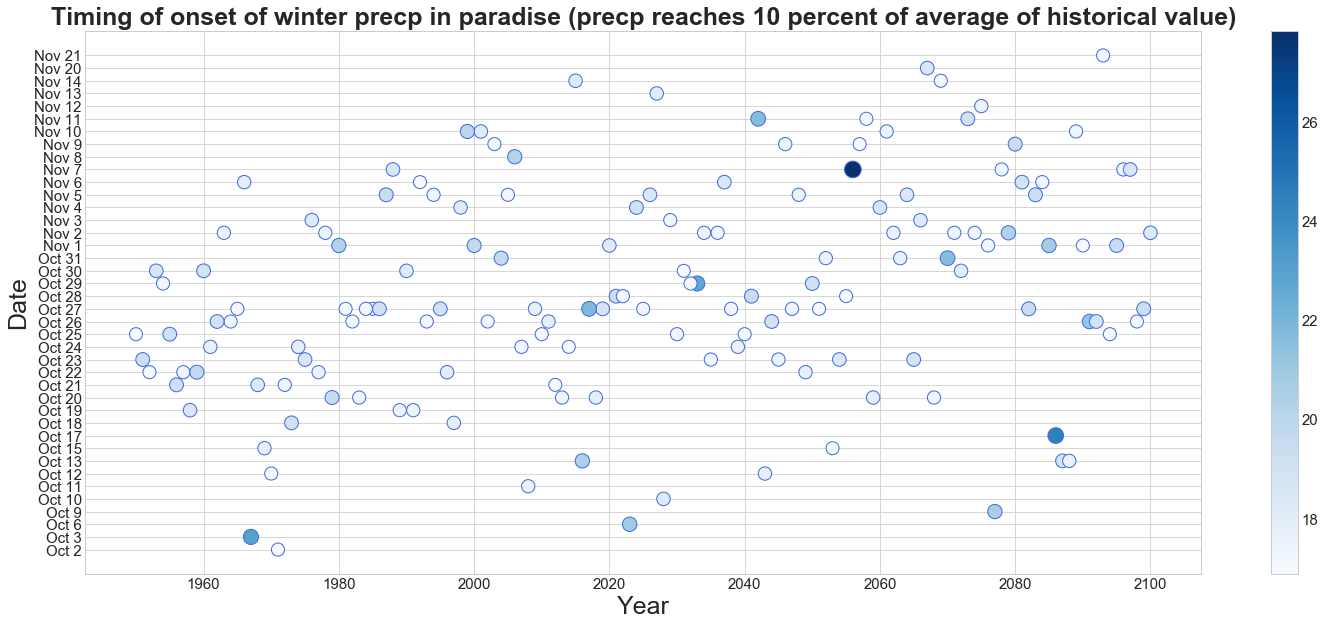

In [95]:
plt.scatter(x = df2.index, y = df2.Date, s = df2.total_precp_by_Date_on_left_column*10, alpha = 1, c = df2.total_precp_by_Date_on_left_column, cmap = 'Blues', edgecolors='royalblue')
#my_yticks = ['Oct 5', 'Oct 10', 'Oct 15', 'Oct 20', 'Oct 25', 'Oct 30', 'Nov 5', 'Nov 10', 'Nov 15', 'Nov 20', 'Nov 25', 'Nov 30']
#plt.yticks(my_yticks)
plt.grid(True)
plt.rcParams['figure.figsize'] = [25, 15]
plt.xlabel('Year', fontsize = 25)

plt.ylabel('Date', fontsize = 25)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
plt.colorbar()
plt.title('Timing of onset of winter precp in paradise (precp reaches 10 percent of average of historical value)', weight = 'bold', fontsize = 25)
#labels = ['Oct 10', 'Oct 20', 'Oct 30', 'Nov 10', 'Nov 20', 'Nov 30']
ax = plt.gca() # grab the current axis
plt.style.use('seaborn-whitegrid')
#ax.set_yticklabels(labels) # set the labels to display at those ticks
#plt.axhline(y= 'Nov 10', alpha = 0.9, color = 'g', linewidth = 1.0)
#plt.axhline(y= 'Oct 18', alpha = 0.9, color = 'g', linewidth = 1.0)
plt.show()

Text(0.5, 1.0, 'Timing of onset of winter precp (threshold = 10% of average of historical precp)')

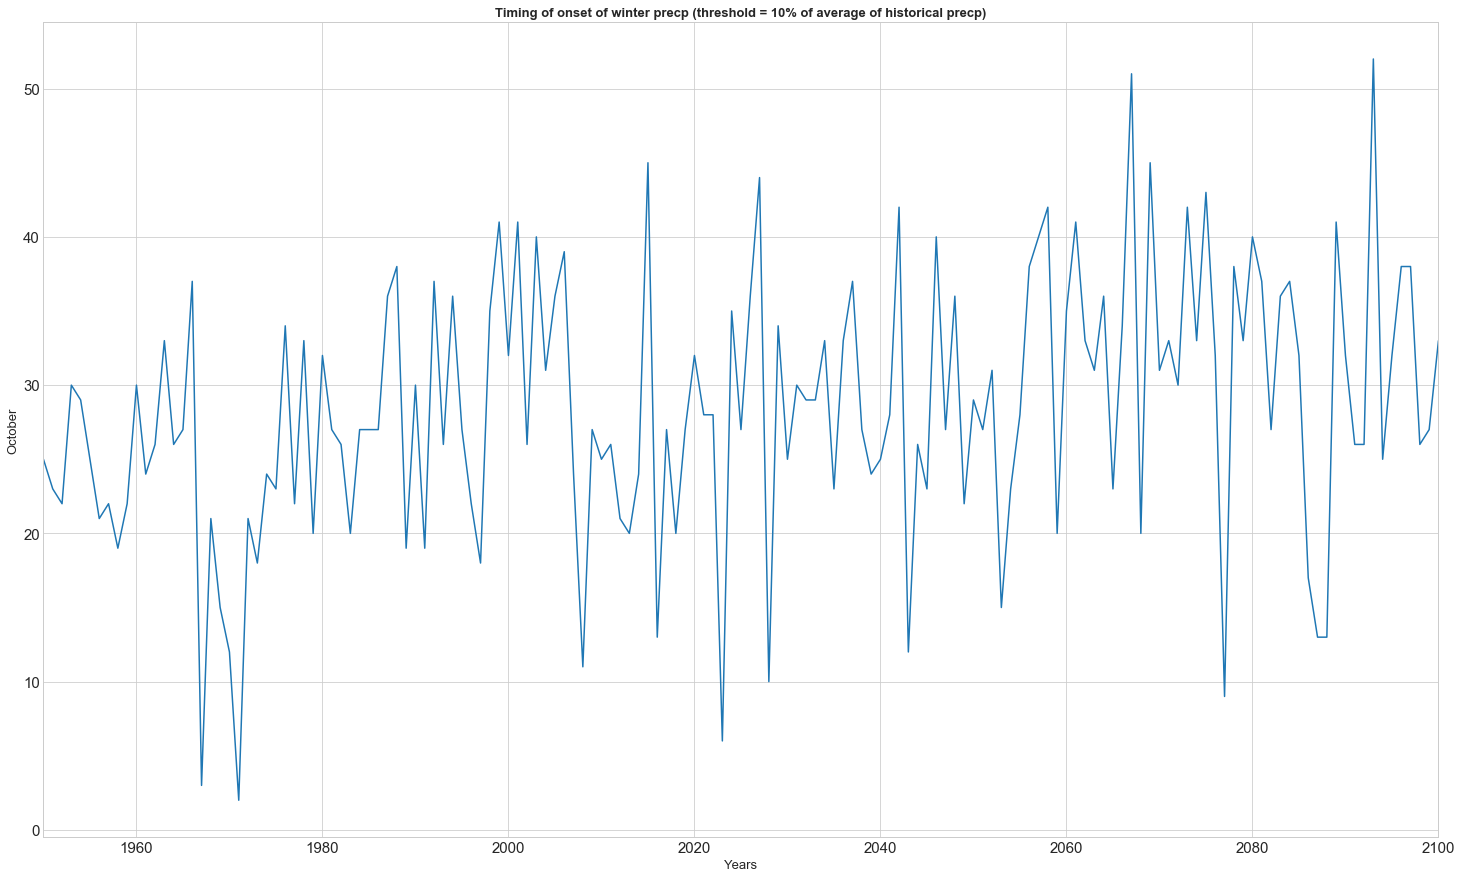

In [70]:
df['threshold'].plot()
plt.grid(True)
plt.rcParams['figure.figsize'] = [15, 8]
plt.xlabel('Years', fontsize = 13)
plt.ylabel('October', fontsize = 13)
plt.title('Timing of onset of winter precp (threshold = 10% of average of historical precp)', weight = 'bold', fontsize = 13)

### To get 10% of every single year

In [71]:
test = wind.pivot_table( values = 'avg', index = 'period', columns = 'year').loc['09-30':'12-31']

In [72]:
test.tail()

year,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
period,,,,,,,,,,,,,,,,,,,,,
12-27,4.598372,6.863042,1.939154,5.620863,4.034788,4.700023,2.103524,3.721452,3.157139,6.531841,...,1.166599,3.983093,2.051791,3.853201,2.001106,6.583017,8.975573,1.027585,1.021052,0.867195
12-28,4.937475,3.367942,2.187887,6.251772,4.825073,3.545572,2.679725,2.878656,2.579778,4.942714,...,2.546885,0.851674,1.278139,9.673763,0.739897,5.699200,9.787364,1.608777,4.627593,1.720435
12-29,5.635726,3.014418,8.476345,4.223564,7.023786,0.499011,1.733333,6.087507,2.216535,5.397315,...,2.549425,0.373398,0.337829,8.000799,1.758600,1.534207,10.324493,2.686591,7.321340,5.264103
12-30,3.803859,5.334012,2.063532,1.985353,4.848098,2.108496,2.708450,3.697958,2.100200,3.234640,...,6.842288,2.364050,3.275631,2.106692,8.157411,3.380015,12.731197,2.451118,5.502981,4.807841
12-31,3.091398,10.155314,3.587530,0.636247,7.755706,1.559886,1.009064,2.126932,7.904489,5.127765,...,4.551004,3.746541,3.167718,1.179667,5.493492,2.419658,9.508834,4.191331,2.359469,4.115626


In [73]:
#test.to_excel("C:/Users/lkaur/Work Python Cookbooks/Wind Data Four GCM/output.xlsx", header = True)

### Onset of winter precp

In [74]:
# Summing precp month wise Onset 
threshold = wind.pivot_table( values = 'avg', index = 'month', columns = 'year', aggfunc=np.sum).loc[9:].sum()*0.10

In [75]:
threshold.head()

year
1950    15.548978
1951    18.993062
1952    20.197994
1953    17.779334
1954    17.973355
dtype: float64

In [76]:
wind.head()

Climate Data,avg,year,month,day,period
1950-01-01,4.117819,1950,1,1,01-01
1950-01-02,2.247640,1950,1,2,01-02
1950-01-03,2.271515,1950,1,3,01-03
1950-01-04,4.079623,1950,1,4,01-04
1950-01-05,1.622177,1950,1,5,01-05


In [77]:
cumsum = test.cumsum()

In [78]:
cumsum.head()

year,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
period,,,,,,,,,,,,,,,,,,,,,
09-30,0.061245,0.025917,0.000000,0.002151,1.568648,0.004643,0.117546,0.004898,0.949225,0.000000,...,0.000000,1.210322,0.000000,0.221938,0.000000,0.144943,0.107350,7.407071,1.126466,0.001024
10-01,1.413082,0.025917,0.050319,0.002151,1.568648,0.455727,0.159696,0.334560,2.176470,2.952440,...,0.000000,1.219915,0.102963,0.221938,0.807375,0.635083,1.095393,10.161056,1.910107,0.003388
10-02,1.679512,0.640869,2.549100,0.002151,1.691671,0.455727,0.339211,0.407532,3.303807,8.570987,...,0.000000,1.411064,0.108263,0.226359,1.082429,0.972092,3.949149,13.653498,3.520109,0.003388
10-03,2.149956,0.641378,7.076473,0.396274,1.701338,0.455727,0.658607,0.845055,5.255458,8.852874,...,0.363799,1.501688,0.108263,1.059344,1.082429,1.924937,4.728739,13.686356,5.124112,0.019883
10-04,3.417059,0.916979,8.222441,0.455428,1.976172,0.524951,0.936589,0.845055,5.554496,9.698492,...,1.285071,1.501688,0.108842,1.986561,1.082429,2.406343,4.793200,13.686356,5.161971,0.117658


In [79]:
onset_of_winter_precp = cumsum[cumsum < threshold].count()

In [80]:
onset_of_winter_precp.head()

year
1950    22
1951    23
1952    25
1953    30
1954    29
dtype: int64

Text(0.5, 1.0, 'Timing of onset of winter precp')

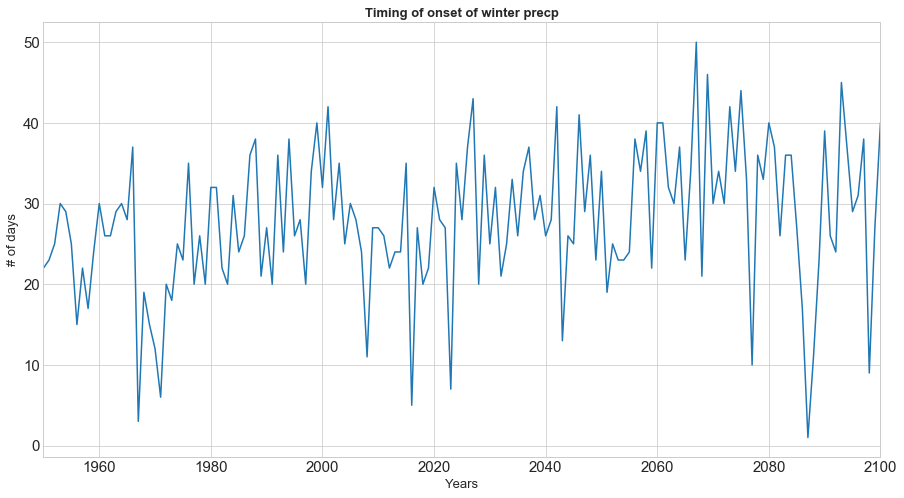

In [81]:
onset_of_winter_precp.plot()
plt.grid(True)
plt.rcParams['figure.figsize'] = [15, 8]
plt.xlabel('Years', fontsize = 13)
plt.ylabel('# of days', fontsize = 13)
plt.title('Timing of onset of winter precp', weight = 'bold', fontsize = 13)

### Wet Day Freq

In [82]:
oct_nov = test.loc['10-01':'11-30']

### Below chart displays a point for each day in October and November in a year when the daily precp  is above the  threshold of 2.54mm 

In [83]:
wind.head()

Climate Data,avg,year,month,day,period
1950-01-01,4.117819,1950,1,1,01-01
1950-01-02,2.247640,1950,1,2,01-02
1950-01-03,2.271515,1950,1,3,01-03
1950-01-04,4.079623,1950,1,4,01-04
1950-01-05,1.622177,1950,1,5,01-05


In [84]:
only_above_threshold = wind[wind.avg >= 2.54]

In [85]:
only_above_threshold.index = pd.to_datetime(only_above_threshold.index)

In [86]:
only_above_threshold = only_above_threshold[(only_above_threshold.month == 10) | (only_above_threshold.month == 11) ]

In [87]:
only_above_threshold.head()

Climate Data,avg,year,month,day,period
1950-10-22,5.072841,1950,10,22,10-22
1950-11-10,3.279520,1950,11,10,11-10
1950-11-12,3.396824,1950,11,12,11-12
1950-11-13,5.054960,1950,11,13,11-13
1950-11-16,4.862930,1950,11,16,11-16


In [88]:
only_above_threshold.index.day

Int64Index([22, 10, 12, 13, 16, 17, 18, 19, 21, 22,
            ...
            18, 19, 29,  8, 18, 19,  5, 14, 29, 30],
           dtype='int64', length=1686)

In [89]:
ascending = only_above_threshold.sort_values(by=['month', 'day'])

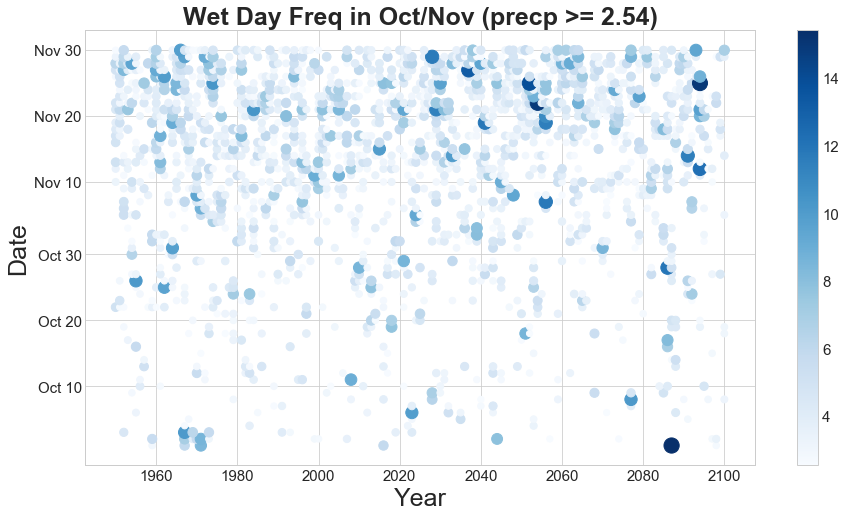

In [90]:
plt.scatter(x = ascending.year, y = ascending['period'], s = ascending.avg * 15, c = ascending.avg, cmap = 'Blues')
my_yticks = ['10-10', '10-20', '10-30', '11-10', '11-20', '11-30']
#plt.yticks(df3['month'], my_yticks)
plt.yticks(my_yticks)
plt.rcParams['figure.figsize'] = [25, 10]
plt.xlabel('Year', fontsize = 25)
plt.ylabel('Date', fontsize = 25)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
plt.colorbar()
plt.title('Wet Day Freq in Oct/Nov (precp >= 2.54)', weight = 'bold', fontsize = 25)
labels = ['Oct 10', 'Oct 20', 'Oct 30', 'Nov 10', 'Nov 20', 'Nov 30']
ax = plt.gca() # grab the current axis
ax.set_yticklabels(labels) # set the labels to display at those ticks
plt.show()

In [91]:
only_above_threshold.index = only_above_threshold.index.strftime('%Y-%m-%d')

In [92]:
x = only_above_threshold['1950-10-22': '1952:11:28']

In [93]:
x.head()

Climate Data,avg,year,month,day,period
1950-10-22,5.072841,1950,10,22,10-22
1950-11-10,3.279520,1950,11,10,11-10
1950-11-12,3.396824,1950,11,12,11-12
1950-11-13,5.054960,1950,11,13,11-13
1950-11-16,4.862930,1950,11,16,11-16


### #of days >= 2.54mm 

In [94]:
wet_day_freq.head()

NameError: name 'wet_day_freq' is not defined

In [ ]:
wet_day_freq.plot()
plt.grid(True)
plt.rcParams['figure.figsize'] = [15, 8]
plt.xlabel('Years', fontsize = 13)
plt.ylabel('# of days', fontsize = 13)
plt.title('Wet Day Frequency', weight = 'bold', fontsize = 13)

In [ ]:
# Trimming the data to only Timeframe that we need
historical = wind.loc['1978-12-24':'2005-12-31']
beg_century = wind.loc['2006-01-01':'2034-12-31']
mid_century = wind.loc['2035-01-01':'2064-12-31']
end_century = wind.loc['2065-12-24':'2099-12-31']

In [ ]:
historical = historical.pivot_table( values = 'avg', index = 'month', columns = 'year')
beg_century = beg_century.pivot_table( values = 'avg', index = 'month', columns = 'year')
mid_century = mid_century.pivot_table( values = 'avg', index = 'month', columns = 'year')
end_century = end_century.pivot_table( values = 'avg', index = 'month', columns = 'year')

In [ ]:
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [15, 6]

In [ ]:
historical['avg'] = historical.mean(axis = 1)
historical['max'] = historical.max(axis = 1)
historical['min'] = historical.min(axis = 1)

beg_century['avg'] = beg_century.mean(axis = 1)
beg_century['min'] = beg_century.max(axis = 1)
beg_century['max'] = beg_century.min(axis = 1)

mid_century['avg'] = mid_century.mean(axis = 1)
mid_century['min'] = mid_century.max(axis = 1)
mid_century['max'] = mid_century.min(axis = 1)

end_century['avg'] = end_century.mean(axis = 1)
end_century['min'] = end_century.min(axis = 1)
end_century['max'] = end_century.max(axis = 1)

In [ ]:
new_order = [7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6]

In [ ]:
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
ax = pl.plot(historical.index, historical.avg, 'k-', color = 'palegreen')
pl.fill_between(historical.index, historical['min'], historical['max'], color = 'palegreen', alpha = 0.2)

pl.plot(beg_century.index, beg_century.avg, color = 'cyan')
pl.fill_between(beg_century.index, beg_century['min'], beg_century['max'], color = 'cyan', alpha = 0.2)

pl.plot(mid_century.index, mid_century.avg, color = 'royalblue')
pl.fill_between(mid_century.index, mid_century['min'], mid_century['max'], color = 'royalblue', alpha = 0.2)

pl.plot(end_century.index, end_century.avg, color = 'chocolate')
pl.fill_between(end_century.index, end_century['min'], end_century['max'], color = 'chocolate', alpha = 0.2)

plt.grid(True)
plt.rcParams['figure.figsize'] = [15, 8]

plt.xlabel('Months', fontsize = 13)
plt.ylabel('Precp (mm/day)', fontsize = 13)
plt.title('Sacramento Precp', weight = 'bold', fontsize = 13)


historical_patch = mpatches.Patch(color='palegreen', label='historical')
beg_century_patch = mpatches.Patch(color='cyan', label='beg_century')
mid_century_patch = mpatches.Patch(color='royalblue', label='mid_century')
end_century_patch = mpatches.Patch(color='chocolate', label='end_century')

plt.legend(handles=[historical_patch, beg_century_patch, mid_century_patch, end_century_patch])

In [ ]:
#directory = r'C:\Users\lkaur\Work Python Cookbooks\= wind project data\rain.csv'
#excel_file = proj_by_years_in_cols.to_csv(directory, header=True) 


In [ ]:
wind.head()

In [ ]:
nineteen_fifty = wind[wind.year == 1950]
two_thousand = wind[wind.year == 2000]
two_thousand_fifty = wind[wind.year == 2050]
two_thousand_ninty = wind[wind.year == 2090]

In [ ]:
cumsum_nineteen_fifty = nineteen_fifty['avg'].cumsum()
cumsum_two_thousand = two_thousand['avg'].cumsum()
cumsum_two_thousand_fifty = two_thousand_fifty['avg'].cumsum()
cumsum_two_thousand_ninty = two_thousand_ninty['avg'].cumsum()